# 2. Preparação e Tratamento de Dados

- objetivo: Realizar a limpeza dos dados (tratamento de nulos, outliers e tipos incorretos) e criar novas variáveis (Feature Engineering) para enriquecer a análise. Entrada: `data/application_train.csv` (apenas colunas selecionadas). Saída: `data/cleaned_data_train.csv`.

## 2.1 Importação de Bibliotecas e Configurações

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

pd.set_option('display.max_columns', None)  # Show all columns when displaying a DataFrame

In [139]:
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (9, 5)

## 2.2 Carga de Dados (Filtrados)

Aqui carregaremos apenas as colunas selecionadas na análise anterior

In [140]:
# Separating only selected columns
selected_columns = [
    # Identifier and Target
    'TARGET', 'SK_ID_CURR',

    # Characteristics of the loan
    'NAME_CONTRACT_TYPE', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 
    'AMT_ANNUITY', 'AMT_GOODS_PRICE',

    # Demographic profile
    'CODE_GENDER', 'CNT_CHILDREN', 'DAYS_BIRTH', 
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',

    # Work and Stability
    'DAYS_EMPLOYED', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',

    # Location and Heritage
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'OWN_CAR_AGE',
    'REGION_RATING_CLIENT', 
    
    # External Score
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'
]

In [141]:
# Load the dataset
df = pd.read_csv('../data/application_train.csv', usecols=selected_columns)
print(f"Data loaded: {df.shape}")

Data loaded: (307511, 22)


## 2.3 Tratamento de Dados

Aqui teremos o tratamento para as seguintes variáveis:

### 2.3.1 Variáveis Numéricas:

Para decidir como iremos substituir os valores nulos ou inconsistentes de cada coluna, analisaremos a distribuição dos dados e calcularemos sua assimetria para ajudar a escolher a melhor substituição. Que poderá ser:
- `0`: Caso o valor `0` seja um valor lógico para aquele tipo de dado
- `MÉDIA`: Para dados simétricos e sem outliers (Assimetria próximo de zero)
- `MEDIANA`: Para dados assimétricos e distribuições com caudas (Assimetria > 1 ou < -1)
---

- `DAYS_EMPLOYED` e `DAYS_BIRTH`: Aqui, temos valores negativos. Teremos que transformar esses valores em positivos

In [142]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].abs()
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].abs()

---

- `AMT_ANNUITY`: Para esta variável existem alguns valores nulos e não podemos substituí-los por `0` (pois não existe empréstimo com valor anual igual a 0). Por isso teremos que analisar sua distribuição e assimetria para escolher entre média ou mediana.

Asymmetry: 1.58


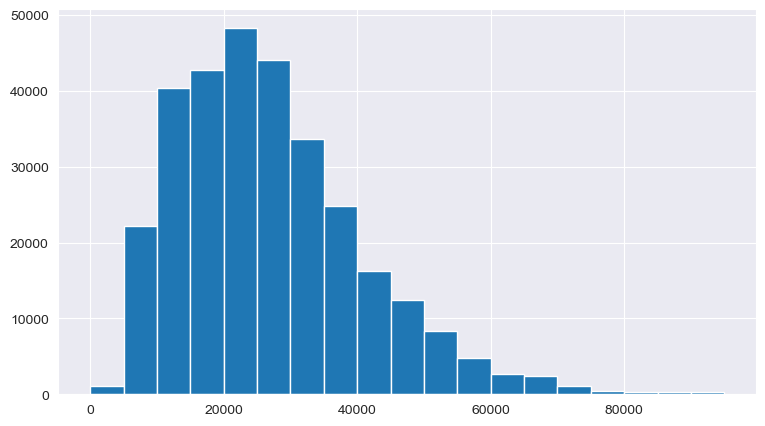

In [143]:
# Analyzing data distribution
plt.hist(df['AMT_ANNUITY'], bins=np.arange(0, 100000, 5000)); #Disregarding some outliers

# Numeric Verification
asymmetry = df['AMT_ANNUITY'].skew()
print(f"Asymmetry: {asymmetry:.2f}")

**Conclusão:** Temos uma distribuição assimétrica (1.58), substituiremos pela mediana.

In [144]:
# Replacing NaN values with the median
df['AMT_ANNUITY'] = df['AMT_ANNUITY'].fillna(df['AMT_ANNUITY'].median())

---
- `AMT_GOODS_PRICE`: Aqui também não podemos substituir o valor por `0`. Portanto vamos analisar a distribuição dos dados

Asymmetry: 1.35


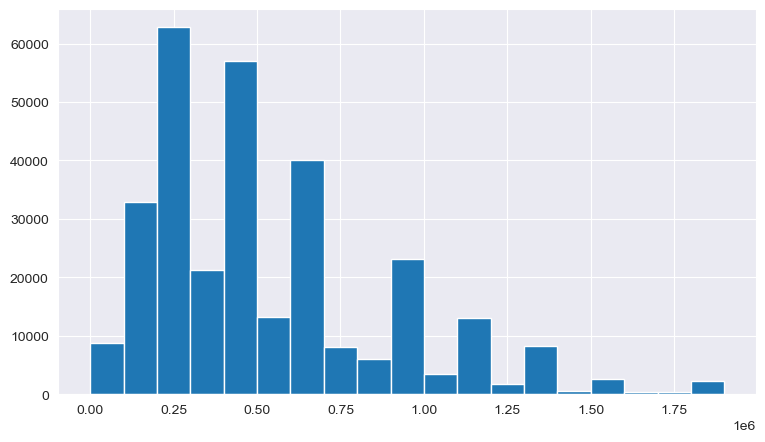

In [145]:
#Analyzing data distribution
plt.hist(df['AMT_GOODS_PRICE'], bins=np.arange(0, 2000000, 100000));

# Numeric Verification
asymmetry = df['AMT_GOODS_PRICE'].skew()
print(f"Asymmetry: {asymmetry:.2f}")


Conclusão: Temos uma distribuição assimétrica (1.35) substituiremos pela mediana.

In [146]:
#Replacing NaN values with the median
df['AMT_GOODS_PRICE'] = df['AMT_GOODS_PRICE'].fillna(df['AMT_GOODS_PRICE'].median())

---
- `OWN_CAR_AGE`: Aqui poderemos ter duas sistuações:
    1. `FLAG_OWN_CAR == 'N'` (substituiremos `OWN_CAR_AGE de NaN para 0`)
    2. `FLAG_OWN_CAR == 'Y'` e `OWN_CAR_AGE = NaN` -> Inconsistência (substituiremos por 0 considerando que o carro seja novo)

In [147]:
#inconsistency
filter = (df['FLAG_OWN_CAR'] == 'Y') & (df['OWN_CAR_AGE'].isna())
df[filter]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
30897,135867,0,Cash loans,M,Y,N,1,495000.0,1006920.0,45630.0,900000.0,Working,Higher education,Separated,16030,1889,NaN,Managers,2,0.339286,0.663192,0.145543
181231,310040,0,Cash loans,F,Y,N,0,112500.0,301464.0,22068.0,238500.0,Commercial associate,Secondary / secondary special,Married,18667,4442,NaN,Medicine staff,2,NaN,0.501713,NaN
217549,352070,0,Cash loans,M,Y,N,0,225000.0,900000.0,26446.5,900000.0,Working,Secondary / secondary special,Married,13502,2256,NaN,Drivers,2,0.378822,0.606717,0.410103
229867,366246,0,Cash loans,F,Y,Y,1,225000.0,518562.0,25078.5,463500.0,Commercial associate,Higher education,Married,13021,944,NaN,Accountants,3,0.685821,0.584590,0.270707
236868,374361,0,Cash loans,F,Y,Y,0,225000.0,233833.5,26577.0,211500.0,Commercial associate,Higher education,Civil marriage,10573,180,NaN,NaN,2,0.353742,0.608615,0.417100


In [148]:
df['OWN_CAR_AGE'] = df['OWN_CAR_AGE'].fillna(0)

---
- `EXT_SOURCE_{1|2|3}`: 

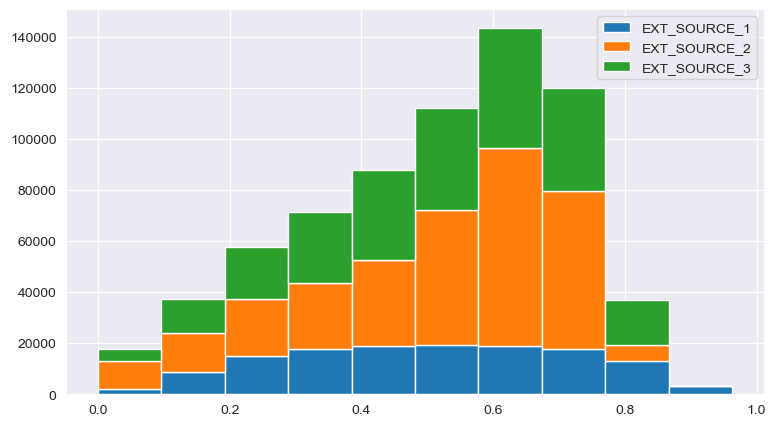

In [149]:
plt.hist([df['EXT_SOURCE_1'],
df['EXT_SOURCE_2'],
df['EXT_SOURCE_3']],
stacked=True)
plt.legend(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']);

- Para `EXT_SOURCE_1` temos uma distribuição normal, portanto substituiremos os valores nulos pela média
- Para `EXT_SOURCE_{2|3}` temos distribuições assimétricas, portanto usaremos a mediana para os dois casos

In [150]:
df['EXT_SOURCE_1'] = df['EXT_SOURCE_1'].fillna(df['EXT_SOURCE_1'].mean())
df['EXT_SOURCE_2'] = df['EXT_SOURCE_2'].fillna(df['EXT_SOURCE_2'].median())
df['EXT_SOURCE_3'] = df['EXT_SOURCE_3'].fillna(df['EXT_SOURCE_3'].median())

### 2.3.2 Variáveis não numéricas:

Aqui temos apenas uma coluna com dados não numéricos faltantes que é a coluna `OCCUPATION_TYPE`. Para ela criaremos um filtro que analise se a pessoa possui uma fonte de renda advinda do esforço de trabalho (`NAME_INCOME_TYPE` = 'working' ou 'state servante' ou 'commercial associate' ou businessman') porém não está definida qual `OCCUPATION_TYPE`. Para linhas desse tipo criaremos uma nova categoria chamada `DESCONHECIDO`.

In [151]:
active_workforce = ['Working', 'State servant', 'Commercial associate', 'Businessman']
non_active_workforce = ['Pensioner', 'Unemployed', 'Student', 'Maternity leave']

filter = (df['OCCUPATION_TYPE'].isna() & df['NAME_INCOME_TYPE'].isin(active_workforce))
df[filter] = df[filter].fillna('Unknown')

filter = (df['OCCUPATION_TYPE'].isna() & df['NAME_INCOME_TYPE'].isin(non_active_workforce))
df[filter] = df[filter].fillna('NA') #Not Applicable

In [152]:
df.isnull().sum()

SK_ID_CURR              0
TARGET                  0
NAME_CONTRACT_TYPE      0
CODE_GENDER             0
FLAG_OWN_CAR            0
FLAG_OWN_REALTY         0
CNT_CHILDREN            0
AMT_INCOME_TOTAL        0
AMT_CREDIT              0
AMT_ANNUITY             0
AMT_GOODS_PRICE         0
NAME_INCOME_TYPE        0
NAME_EDUCATION_TYPE     0
NAME_FAMILY_STATUS      0
DAYS_BIRTH              0
DAYS_EMPLOYED           0
OWN_CAR_AGE             0
OCCUPATION_TYPE         0
REGION_RATING_CLIENT    0
EXT_SOURCE_1            0
EXT_SOURCE_2            0
EXT_SOURCE_3            0
dtype: int64

Agora, temos todos os dados preenchidos e o dataset completo

## 2.4 Análise de Anomalias

Aqui verificaremos se existem anomalias nos dados, indicando possível erro de preenchimento do usuário.
Exemplos de anomalias que poderemos encontrar: Idades absurdamente grandes, ou dias empregados incompatíveis com a idade.
<br>
<br>
No notebook anterior havíamos detectado uma anomalia em `DAYS_EMPLOYED`, vamos começar a distribuição dos valores dessa variável.

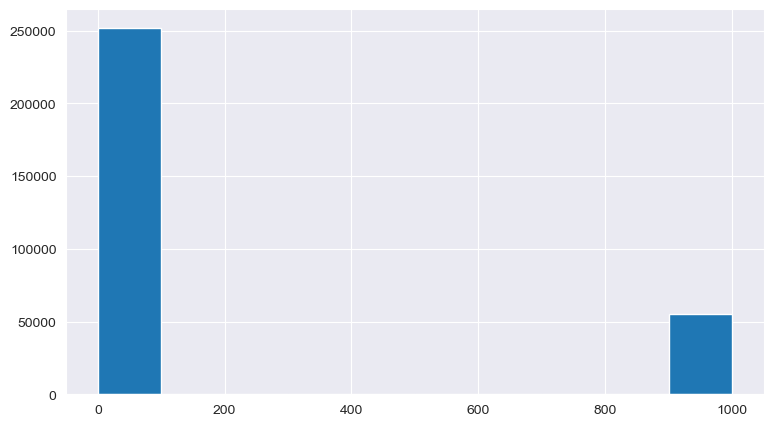

In [153]:
#Calculating variable in years
years_employed = df['DAYS_EMPLOYED'] / 365
plt.hist(years_employed);

Como podemos ver, há uma grande anomalia presente nesses dados visto que temos casos de pessoas que trabalham a quase 1000 anos. Veremos quantos casos desse existem

In [154]:

anom = df[df['DAYS_EMPLOYED'] == 365243].shape[0]
percent = (anom / df.shape[0]) * 100
print(f'Anomalies: {anom}')
print(f'Total percentage: {percent:.2f}%')

Anomalies: 55374
Total percentage: 18.01%


Neste caso não podemos considerar como caso isolado indicando erro de preechimento. Teremos que toma outra abordagem. Vamos verificar o tipo de emprego dessas anomalias.

In [155]:
# Viewing the occupation_type for data with the value 365243
filter = df['DAYS_EMPLOYED'] == 365243
df[filter]['OCCUPATION_TYPE'].value_counts()

OCCUPATION_TYPE
NA                55372
Cleaning staff        2
Name: count, dtype: int64

Isso no mostra uma possível solução que é a de que as pessoas com esse valor anômalo podem ser pessoas desempregadas e esse valore foi colocado para representar essa situação. Por isso, vamos mudar o valor de 365234 para 0 (indicando que essas pessoas não trabalham)

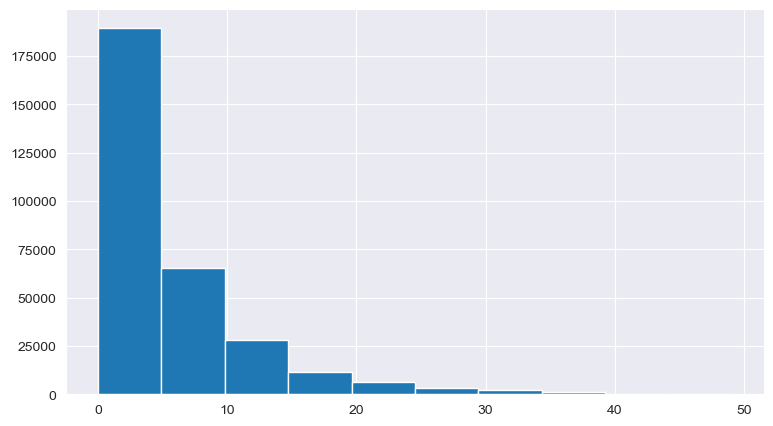

In [156]:
# Changing 365243 by 0
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, 0)
plt.hist(df['DAYS_EMPLOYED']/ 365);

## 2.5 Criando novas métricas (Feature-engineering)

Iremos criar duas novas métricas a fim de enriquecer nossa análise, e ao final veremos se elas foram métricas que agregaram valor ou não.
<br>
As novas métricas (colunas) serão:
- DEBT_TO_INCOME_RATIO = AMT_ANNUITY / AMT_INCOME_TOTAL (Quanto da renda está comprometida?)
    - Hipótese: Quanto maior a parcela de renda está comprometida, maior será a chance de o cliente não conseguir pagar.

- CREDIT_TERM = AMT_CREDIT / AMT_ANNUITY (Quanto tempo vai demorar para pagar?
    - Hipótese: Quanto maior o período da dívida, mais chances do cliente não conseguir segurar e deixar de pagar.

---
- `DEBT_TO_INCOME_RATIO`: 

In [ ]:

df['DEBT_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

In [168]:
print(f'Null values for DEBT_TO_INCOME_RATIO = {df['DEBT_TO_INCOME_RATIO'].isnull().sum()}')

Null values for DEBT_TO_INCOME_RATIO = 0


---
- `CREDIT_TERM`: 

In [169]:
df['CREDIT_TERM'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']

In [171]:
print(f'Null values for CREDIT_TERM = {df['CREDIT_TERM'].isnull().sum()}')

Null values for CREDIT_TERM = 0


In [172]:
#Final dataset
df.head(n=50)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DEBT_TO_INCOME_RATIO,CREDIT_TERM
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,9461,637,0.0,Laborers,2,0.083037,0.262949,0.139376,0.121978,16.461104
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,16765,1188,0.0,Core staff,1,0.311267,0.622246,0.535276,0.132217,36.234085
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,19046,225,26.0,Laborers,2,0.502130,0.555912,0.729567,0.100000,20.000000
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,19005,3039,0.0,Laborers,2,0.502130,0.650442,0.535276,0.219900,10.532818
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.0,21865.5,513000.0,Working,Secondary / secondary special,Single / not married,19932,3038,0.0,Core staff,2,0.502130,0.322738,0.535276,0.179963,23.461618
5,100008,0,Cash loans,M,N,Y,0,99000.000,490495.5,27517.5,454500.0,State servant,Secondary / secondary special,Married,16941,1588,0.0,Laborers,2,0.502130,0.354225,0.621226,0.277955,17.824857
6,100009,0,Cash loans,F,Y,Y,1,171000.000,1560726.0,41301.0,1395000.0,Commercial associate,Higher education,Married,13778,3130,17.0,Accountants,2,0.774761,0.724000,0.492060,0.241526,37.789061
7,100010,0,Cash loans,M,Y,Y,0,360000.000,1530000.0,42075.0,1530000.0,State servant,Higher education,Married,18850,449,8.0,Managers,3,0.502130,0.714279,0.540654,0.116875,36.363636
8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,913500.0,Pensioner,Secondary / secondary special,Married,20099,0,0.0,NA,2,0.587334,0.205747,0.751724,0.300680,30.142344
9,100012,0,Revolving loans,M,N,Y,0,135000.000,405000.0,20250.0,405000.0,Working,Secondary / secondary special,Single / not married,14469,2019,0.0,Laborers,2,0.502130,0.746644,0.535276,0.150000,20.000000
